##### This notebook will identifiy trends in NDVI for a given time period from Landsat 8 L1 data
Author: Maanas Nukala 

Date: 1/9/2020

### 1. Inputs

Format for bounding box: `[x1, y1, x2, y2]`

In [1]:
BBOX = [-120.092387, 36.85121, -120.055737, 36.873116]
DATETIME = '2019-09-01/2019-09-28'
MAX_CLOUD_COVER = 5

### 2. Search for scenes

Obtain Spatio-Temporal Asset Catalog (STAC):

In [2]:
from satsearch import Search
from satstac import Catalog, Collection, Item

search = Search.search(bbox=BBOX, datetime=DATETIME, collection='landsat-8-l1', 
                       property=['eo:cloud_cover<'+str(MAX_CLOUD_COVER)]
)

print('Found %s scenes' % search.found())

Found 9 scenes


View collection dates of scenes in STAC:

In [3]:
scenes = search.items()
print(scenes.calendar())

                              2019                              

        July                 August              September      
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7            1  2  3  4                     1  
 8  9 10 11 12 13 14   5  6  7  8  9 10 11   2  3  4  5  6  7  8  
15 16 17 18 19 20 21  12 13 14 15 16 17 18   9 10 11 12 13 14 15  
22 23 24 25 26 27 28  19 20 21 22 23 24 25  16 17 18 19 20 21 22  
29 30 31              26 27 28 29 30 31     23 24 25 26 27 28 29  

landsat-8 (1)
8 total dates


### 3. Download NIR and RED bands

Obtain urls from STAC for each band

In [4]:
nir_url = scenes[0].assets['B5']['href']
red_url = scenes[0].assets['B4']['href']

Function to write destination `.TIF` file from `url (str)` and `filename (str)`

In [5]:
import requests
from tqdm.notebook import tqdm

def download_tif (tif_url, filename=False):
    tif_response = requests.get(tif_url, stream=True)
    file_size = int(tif_response.headers['Content-Length'])
    chunk = 1,
    CHUNK_SIZE = 1024
    NUM_BARS = int(file_size / CHUNK_SIZE)
    with open(filename, 'wb') as handle:
        for chunk in tqdm (
            tif_response.iter_content(chunk_size=CHUNK_SIZE),
            total=NUM_BARS,
            unit='KB',
            desc=filename,
            leave=True
        ):
            handle.write(chunk)

Download data as `.TIF`

In [6]:
# download nir data
download_tif(nir_url, filename='nir_test.tif')

In [7]:
# downdload red data
download_tif(red_url, filename='red_test.tif')

### 4. Convert `BBOX` TO `.SHP`

In [9]:
import geopandas as gpd
from shapely.geometry import Polygon
from fiona.crs import from_epsg

polygon_geom = Polygon([
    [BBOX[0], BBOX[1]],
    [BBOX[2], BBOX[1]],
    [BBOX[2], BBOX[3]],
    [BBOX[0], BBOX[3]],
    [BBOX[0], BBOX[1]]
])
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0], crs=from_epsg(4326), geometry=[polygon_geom])       
polygon.to_file(filename='bbox.shp', driver='ESRI Shapefile')

Open `.SHP` as geodataframe

In [10]:
ripperdan_nw = gpd.read_file('bbox.shp')

### 5. Clip `.TIFs` by AOI

In [11]:
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pycrs

Function to get coords of geometry in rasterio format

In [12]:
def get_features(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

Function to clip rasters by `geo`

In [20]:
def clip_tif(in_tif, bbox, out_tif):
    # load raster data
    in_data = rio.open(in_tif)
    
    # reproject bbox crs to landsat crs
    geo = bbox.to_crs(crs=in_data.crs.data)
    
    # get coords
    coords = get_features(geo)
    
    # clip by coords
    out_img, out_transform = mask(dataset=in_data, shapes=coords, crop=True)
    
    # modify metadata
    out_meta = in_data.meta.copy()
    epsg_code = int(in_data.crs.data['init'][5:])
    out_meta.update({'driver': 'GTiff',
                'height': out_img.shape[1],
                'width': out_img.shape[2],
                'transform': out_transform,
                'crs': pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    # save out_tif
    with rio.open(out_tif, 'w', **out_meta) as dest:
        dest.write(out_img)

In [21]:
clip_tif('nir_test.tif', ripperdan_nw, 'nir_clip.tif')

In [22]:
clip_tif('red_test.tif', ripperdan_nw, 'red_clip.tif')

### 6. Calculate NDVI

In [33]:
import matplotlib.pyplot as plt

In [30]:
# open dataset
b4 = rio.open(r'red_clip.tif')
b5 = rio.open(r'nir_clip.tif')

# read data as arrays
nir = b5.read(1)
red = b4.read(1)

In [31]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

/home/paperspace/maanas/envs/falco/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


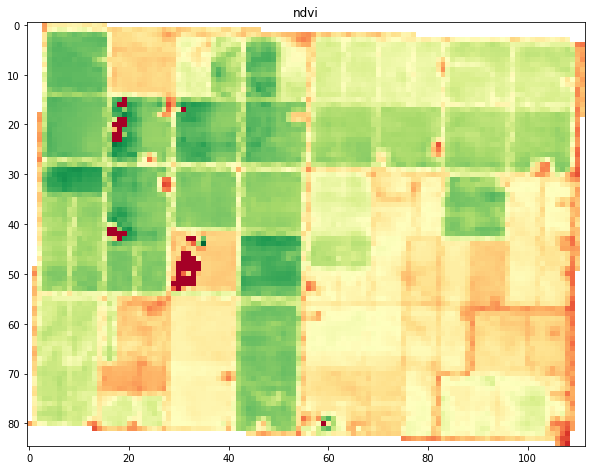

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('ndvi')
implot = plt.imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=0.5)